The loss function for the deadtime model Poisson point process is:

$$ L = \sum_{m=1}^{M}{[N_{shots}\lambda(t_m)\Delta t H_{m}^{(I)} - ln(\lambda(t_m)) H_{m}^{(P)}]} $$

Please refer to Matt Hayman's reference notes on this topic for a description of the terms. Basically $H_{m}^{(I)}$ is the histogram (normalized) of the active time of the detector (this is where the Poisson point process inherits the effect of deadtime). $H_{m}^{(P(}$ is the detection histogram.

Analytically minimizing the loss function per grid bin $m$ (assuming Riemann sum for $\Lambda$):

$$ \frac{dL}{d\lambda(t_m)} = 0 = N_{shots}\Delta t H_{m}^{(I)} - \frac{1}{\lambda(t_m)}H_{m}^{(P)} $$
$$ \lambda(t_m) =  \frac{H_{m}^{(P)}}{N_{shots}\Delta t H_{m}^{(I)}}$$

I'm doing this by treating each time bin essentially as its own independent detector. The result will be a noisy fit compared to the maximum likelihood gradient descent approach that constrains the entire function as a sum over the bins, but this can be analytically solved and should at least show an approximation of what the function should "generally" look like.

In [1]:
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import os, sys
import xarray as xr
import pandas as pd

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

from load_ARSENL_data import load_INPHAMIS_data, set_binwidth
import data_organize as dorg
import fit_polynomial_utils as fit

import matplotlib as mpl
mpl.rcParams.update({"figure.facecolor": "white"})

### First obtain $H_{m}^{(P)}$

In [2]:
# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = False  # Set TRUE to generate a .csv from .ARSENL data
load_data = True  # Set TRUE to load data into a DataFrame and serialize into a pickle object
window_bnd = [30e-9, 40e-9]  # [s] Set temporal boundaries for binning
dt = 25e-12  # [s] Resolution
deadtime = 29.1e-9  # [s]

data_dir = r'C:\Users\jason\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Data\SPCM_Data_2023.03.06/'
fname = r'\OD39_Dev_0_-_2023-03-06_14.23.19_OD3.9.ARSENL.nc'
OD = float(fname[3:5])/10

max_lsr_num = int(1e5)
exclude_shots = True

In [3]:
ds = xr.open_dataset(data_dir + fname)

t_min = window_bnd[0]
t_max = window_bnd[1]

cnts = ds.time_tag
flight_time = cnts * dt  # [s]
# Exclude specified t.o.f. bins
flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]

n_shots = len(ds.sync_index)

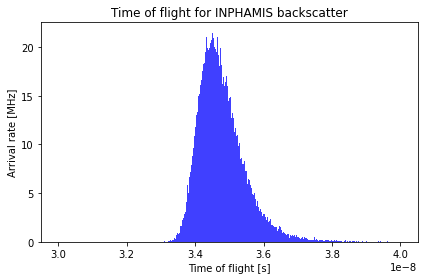

In [4]:
### Histogram of time of flight ###
fig = plt.figure()
ax1 = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots
center = 0.5 * (bins[:-1]+bins[1:])
ax1.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.75)
ax1.set_xlabel('Time of flight [s]')
ax1.set_ylabel('Arrival rate [MHz]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
plt.tight_layout()
plt.show()

In [5]:
H_P = n

### Next obtain $H_{m}^{(I)}$

In [6]:
intgrl_N = len(n)

In [7]:
flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, max_lsr_num,
                                                                 exclude_shots)

active_ratio_hst_ref = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)

Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100005)...


In [8]:
H_I = active_ratio_hst_ref

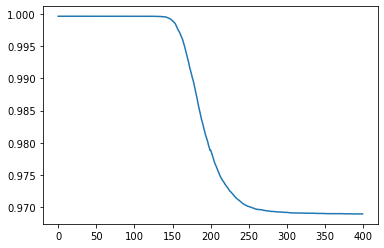

In [9]:
plt.plot(active_ratio_hst_ref)
plt.show()

### Now generate analytic solution to minimized loss function

In [10]:
lamb = H_P/H_I/dt/n_shots  # [Hz]

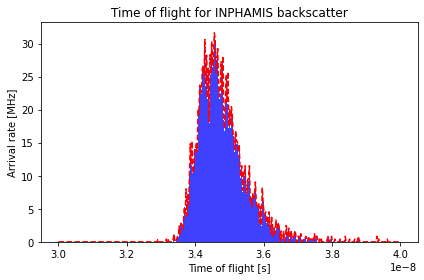

In [11]:
### Histogram of time of flight ###
fig = plt.figure()
ax1 = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots
center = 0.5 * (bins[:-1]+bins[1:])
ax1.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.75)
ax1.plot(center, N/H_I/1e6, 'r--')
ax1.set_xlabel('Time of flight [s]')
ax1.set_ylabel('Arrival rate [MHz]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
plt.tight_layout()

save_loc = r'C:\Users\jason\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Figures\scale_bins_deadtime_03.06.23_data'
save_name = r'\OD{}.png'.format(OD)
plt.savefig(save_loc+save_name)
plt.show()

### To automate this, loop over all the files.

In [14]:
files = []
OD_lst = []
for file in os.listdir(data_dir):
    if file.endswith(".ARSENL.nc"):
        files.append(file)
        OD_lst.append(float(file[2:4])/10)

In [15]:
save_dir = r'C:\Users\jason\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss'
save_csv_file = r'\active_ratio_hist_{}{:.1E}-{:.1E}_shots{:.2E}_best_fit.csv'.format('OD', OD_lst[0], OD_lst[-1],  n_shots)

In [ ]:
H_I_lst = []
t_min = window_bnd[0]
t_max = window_bnd[1]

start = time.time()
for i in range(len(files)):
    fname = files[i]
    ds = xr.open_dataset(os.path.join(data_dir, fname))

    cnts = ds.time_tag
    flight_time = cnts * dt  # [s]
    # Exclude specified t.o.f. bins
    flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]

    n_shots = len(ds.sync_index)
    
    H_P = n
    
    intgrl_N = len(n)
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, max_lsr_num, exclude_shots)
    active_ratio_hst_ref = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
    
    H_I = active_ratio_hst_ref.numpy()
    
    H_I_lst.append(H_I)
    
print('Time elapsed: {:.2f} s'.format(time.time()-start))

In [32]:
np.shape(np.array(H_I_lst).T.tolist())

(400, 2)

In [43]:
headers = ['OD'+str(i) for i in OD_lst]
df_out = pd.DataFrame(np.array(H_I_lst).T.tolist())
df_out = df_out.to_csv(save_dir + save_csv_file, header=headers)

### Overlay scaling with the fit

In [16]:
load_dir = save_dir
fname_dead_fit = r'\eval_loss_dtimeTrue_OD1.5E+00-5.0E+00_order7-23_shots1.00E+05_best_fit_term1e-7.csv'
fname_active_ratio_hist = r'\active_ratio_hist_OD1.0E+00-5.0E+00_shots1.00E+05_best_fit.csv'

load_ttag_loc = load_dir + r'\fit_figures'
fname_ttag = r'\params_eval_loss_dtimeTrue_OD1.5E+00-5.0E+00_order7-23_ref_shots6.00E+06_lsr_shots1.00E+05_best_fit.pkl'

save_loc = r'C:\Users\jason\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Figures\compare_scale_bins_term1e-7_03.06.23_data'

In [17]:
df_dead_fit = pd.read_csv(load_dir + fname_dead_fit)
df_active_ratio_hist = pd.read_csv(load_dir + fname_active_ratio_hist)

infile_ttag = open(load_ttag_loc+fname_ttag, 'rb')
load_ttag = pickle.load(infile_ttag)

In [18]:
flight_time_lst = load_ttag[0]
flight_time_ref_lst = load_ttag[1]
t_min = load_ttag[2]
t_max = load_ttag[3]
dt = load_ttag[4]
n_shots = load_ttag[5]
n_shots_ref = load_ttag[6]
active_ratio_hst_lst = load_ttag[7]

In [19]:
t_fine = df_dead_fit['time vector']

In [20]:
OD_lst = []
OD_name_lst = []
for column in df_dead_fit:
    if column[:2] == 'OD':    
        OD_lst.append(float(column[2:]))
        OD_name_lst.append(column)
print('OD values investigated: {}'.format(OD_lst))

OD values investigated: [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 5.0]


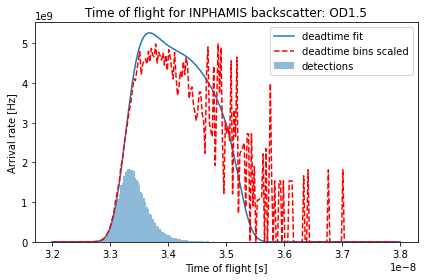

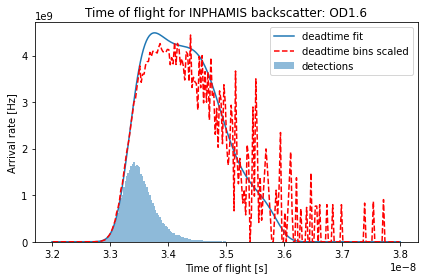

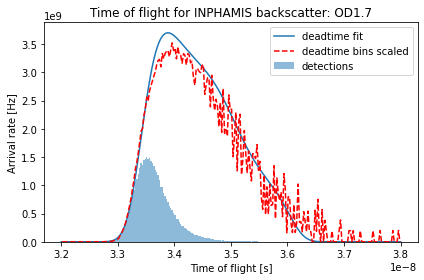

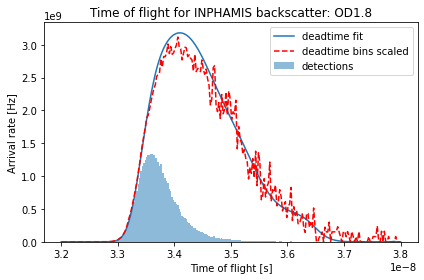

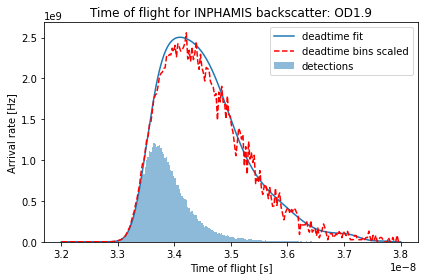

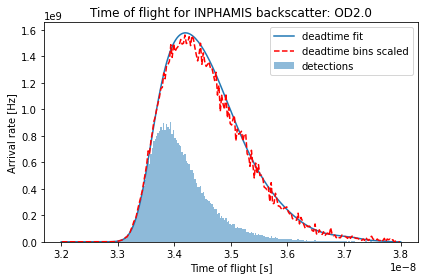

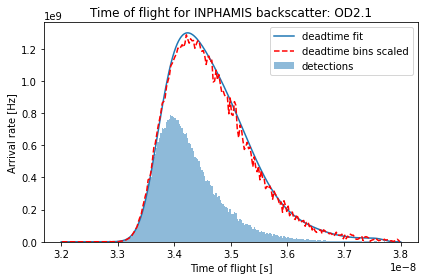

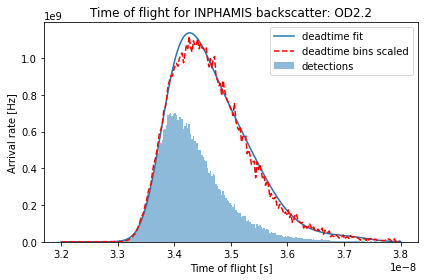

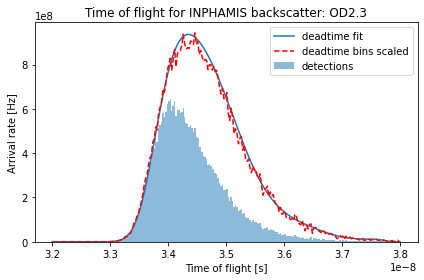

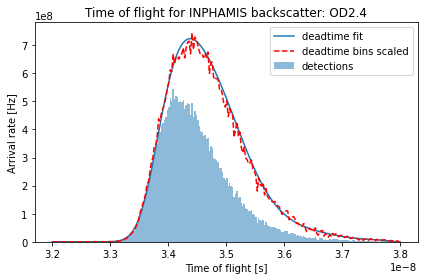

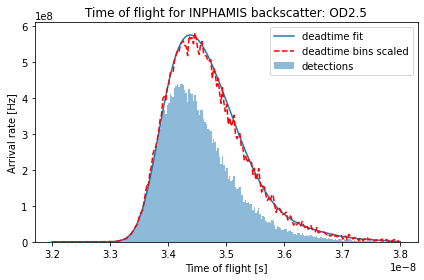

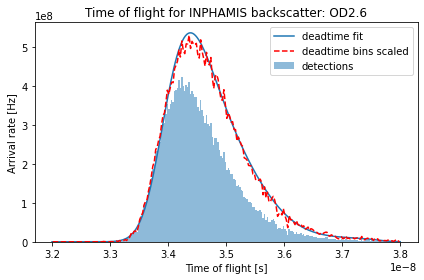

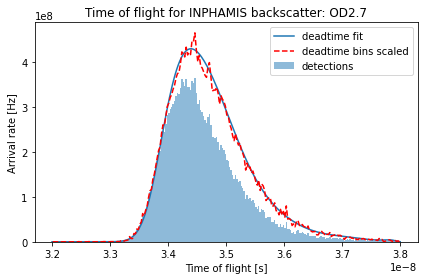

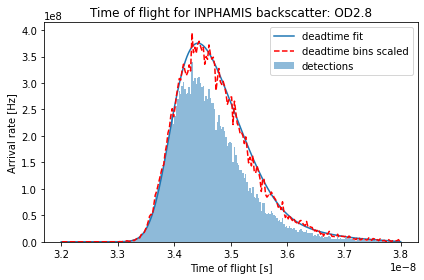

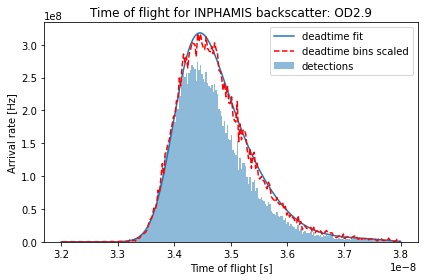

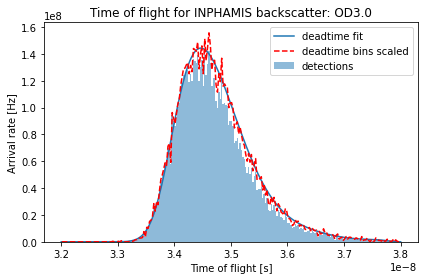

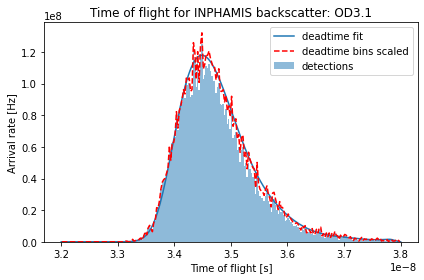

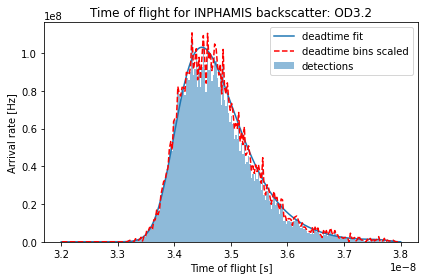

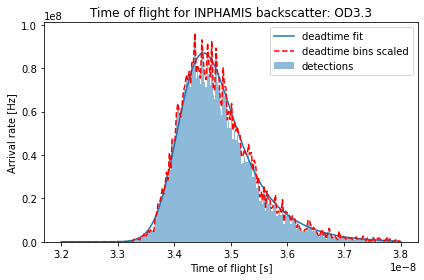

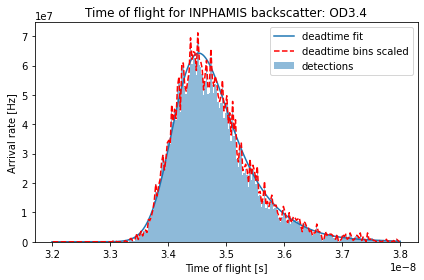

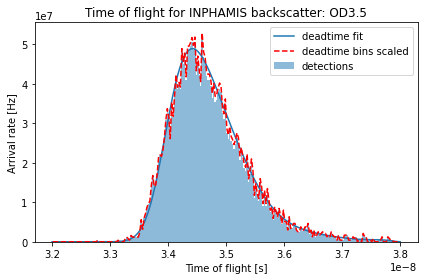

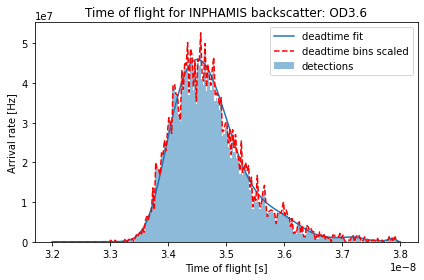

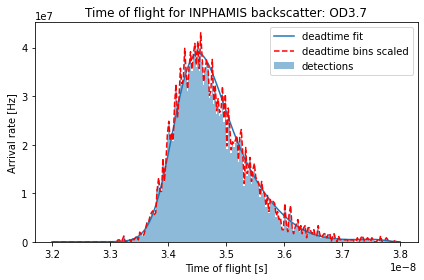

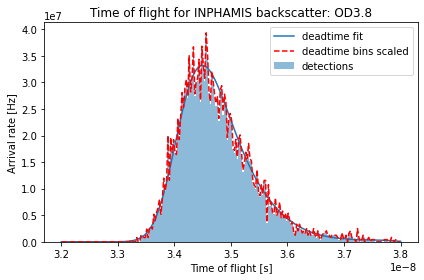

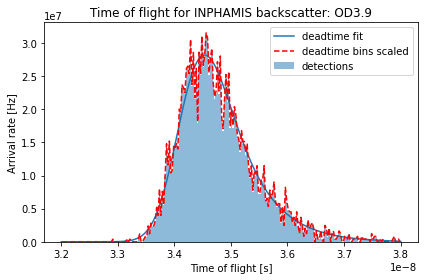

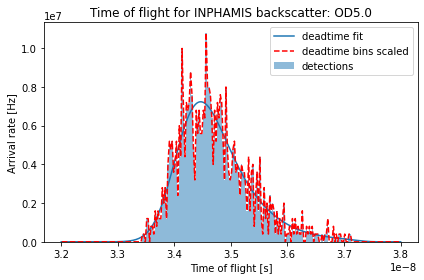

In [21]:
for i in range(len(OD_lst)):
    fit_dead = df_dead_fit['OD'+str(OD_lst[i])]
    H_I = active_ratio_hst_lst[i][:-1].numpy().T[0]
    ### Histogram of time of flight ###
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t_fine, fit_dead, label='deadtime fit')
    
    flight_time = flight_time_lst[i]
    bin_array = set_binwidth(t_min, t_max, dt)
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz]
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, alpha=0.5, label='detections')
    ax.plot(center, N/H_I, 'r--', label='deadtime bins scaled')
    ax.set_xlabel('Time of flight [s]')
    ax.set_ylabel('Arrival rate [Hz]')
    ax.set_title('Time of flight for INPHAMIS backscatter: OD{}'.format(OD_lst[i]))
    plt.tight_layout()
    plt.legend()

    save_name = r'\OD{}.png'.format(OD_lst[i])
    plt.savefig(save_loc+save_name)
    plt.show()